# Determine how to remove spatial trend (mainly SIF)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from seaborn import pairplot

import spatial_tools
import fields
import plot
from stat_tools import standardize

## Setup the data

In [4]:
# Get data: 4x5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_4x5deg_monthly_conus_augmented.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

In [5]:
# Analysis variables
month = 8
timedelta = -2
fast_dist = True

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")
timestamp = timestamps[0]

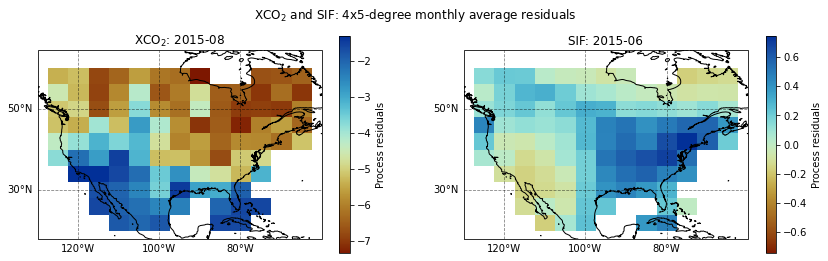

In [6]:
# NOTE: make sure that spatial trend isn't already removed in preprocessing!
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, fast_dist=fast_dist)
plot.plot_fields(mf);

## Fit different surface models for SIF

In [7]:
f = mf.field_2
df = pd.DataFrame({
    "lat": f.coords[:, 0],
    "lon": f.coords[:, 1],
    "values": f.values
    })
df[["lat", "lon"]] = df[["lat", "lon"]].apply(lambda x: standardize(x), axis=0)
df

lat       lon    values
0    -1.710263 -0.537086  0.153525
1    -1.710263 -0.268543  0.229239
2    -1.710263  0.537086  0.023747
3    -1.710263  0.805629  0.496334
4    -1.666410 -0.537086  0.118498
...        ...       ...       ...
1760  1.710263 -0.268543 -0.062090
1761  1.710263  0.000000 -0.081172
1762  1.710263  1.074172 -0.203594
1763  1.710263  1.342715 -0.150557
1764  1.710263  1.611258 -0.155445

[1765 rows x 3 columns]

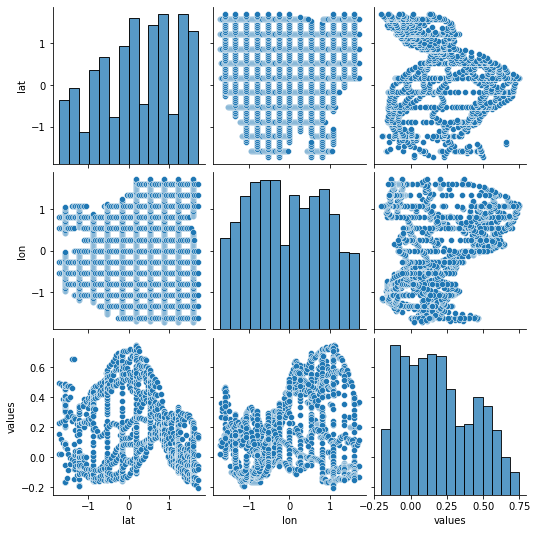

In [8]:
pairplot(df)

In [9]:
res_base = smf.ols(formula='values ~ lat + lon', data=df).fit()
res_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     153.7
Date:                Sat, 07 Aug 2021   Prob (F-statistic):           2.91e-62
Time:                        07:10:24   Log-Likelihood:                 175.00
No. Observations:                1765   AIC:                            -344.0
Df Residuals:                    1762   BIC:                            -327.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2104      0.005     39.074      0.000       0.200       0.221
lat           -0.0483      0.006     -8.571      0.000      -0.059      -0.037
lon            0.0896      0.006     15.636      0.000       0.078       0.101
==============================================================================
Omnibus:                      407.909   Durbin-Watson:                   0.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.950
Skew:                          -0.016   Prob(JB):                     5.31e-17
Kurtosis:                       1.991   Cond. No.                         1.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
res = smf.ols(formula='values ~ lon * lat', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     461.3
Date:                Sat, 07 Aug 2021   Prob (F-statistic):          3.95e-221
Time:                        05:38:34   Log-Likelihood:                 544.83
No. Observations:                1765   AIC:                            -1082.
Df Residuals:                    1761   BIC:                            -1060.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2217      0.004     50.590      0.000       0.213       0.230
lon            0.1677      0.005     31.545      0.000       0.157       0.178
lat           -0.0610      0.005    -13.292      0.000      -0.070      -0.052
lon:lat       -0.1682      0.006    -30.277      0.000      -0.179      -0.157
==============================================================================
Omnibus:                       18.942   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.854
Skew:                          -0.047   Prob(JB):                     3.29e-07
Kurtosis:                       3.630   Cond. No.                         1.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
res = smf.ols(formula='values ~ np.power(lat, 2) + np.power(lon, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     217.9
Date:                Sat, 07 Aug 2021   Prob (F-statistic):           2.66e-85
Time:                        05:46:15   Log-Likelihood:                 228.14
No. Observations:                1765   AIC:                            -450.3
Df Residuals:                    1762   BIC:                            -433.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3424      0.009     37.847      0.000       0.325       0.360
np.power(lat, 2)    -0.1105      0.006    -18.717      0.000      -0.122      -0.099
np.power(lon, 2)    -0.0576      0.006     -9.166      0.000      -0.070      -0.045
==============================================================================
Omnibus:                      131.205   Durbin-Watson:                   0.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.049
Skew:                           0.105   Prob(JB):                     6.07e-11
Kurtosis:                       2.228   Cond. No.                         3.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
res = smf.ols(formula='values ~ np.power(lat, 3) * np.power(lon, 3)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     165.2
Date:                Sat, 07 Aug 2021   Prob (F-statistic):           2.27e-94
Time:                        06:09:36   Log-Likelihood:                 251.94
No. Observations:                1765   AIC:                            -495.9
Df Residuals:                    1761   BIC:                            -474.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.2127      0.005     41.532      0.000       0.203       0.223
np.power(lat, 3)                     -0.0357      0.003    -12.551      0.000      -0.041      -0.030
np.power(lon, 3)                      0.0606      0.004     16.004      0.000       0.053       0.068
np.power(lat, 3):np.power(lon, 3)    -0.0346      0.002    -17.176      0.000      -0.039      -0.031
==============================================================================
Omnibus:                      135.857   Durbin-Watson:                   0.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.389
Skew:                           0.337   Prob(JB):                     1.91e-16
Kurtosis:                       2.272   Cond. No.                         3.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
res = smf.ols(formula='values ~ lon * lat + np.power(lon, 2) * np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     455.1
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        05:48:17   Log-Likelihood:                 860.35
No. Observations:                1765   AIC:                            -1707.
Df Residuals:                    1758   BIC:                            -1668.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.3508      0.007     46.867      0.000       0.336       0.365
lon                                   0.1673      0.004     37.275      0.000       0.159       0.176
lat                                  -0.0325      0.004     -7.811      0.000      -0.041      -0.024
lon:lat                              -0.1696      0.005    -36.288      0.000      -0.179      -0.160
np.power(lon, 2)                     -0.0382      0.006     -5.901      0.000      -0.051      -0.025
np.power(lat, 2)                     -0.1192      0.006    -19.925      0.000      -0.131      -0.107
np.power(lon, 2):np.power(lat, 2)     0.0066      0.005      1.287      0.198      -0.003       0.017
==============================================================================
Omnibus:                       33.726   Durbin-Watson:                   0.527
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.719
Skew:                          -0.264   Prob(JB):                     1.44e-09
Kurtosis:                       3.525   Cond. No.                         6.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
res = smf.ols(formula='values ~ lon * lat + np.power(lon, 2) * np.power(lat, 2) + np.power(lon, 3) * np.power(lat, 3)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     349.4
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        06:10:13   Log-Likelihood:                 939.06
No. Observations:                1765   AIC:                            -1858.
Df Residuals:                    1755   BIC:                            -1803.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.3547      0.007     49.454      0.000       0.341       0.369
lon                                   0.2331      0.009     27.251      0.000       0.216       0.250
lat                                   0.0404      0.009      4.459      0.000       0.023       0.058
lon:lat                              -0.1596      0.007    -23.139      0.000      -0.173      -0.146
np.power(lon, 2)                     -0.0559      0.006     -8.757      0.000      -0.068      -0.043
np.power(lat, 2)                     -0.1192      0.006    -20.783      0.000      -0.130      -0.108
np.power(lon, 2):np.power(lat, 2)     0.0195      0.005      3.829      0.000       0.010       0.029
np.power(lon, 3)                     -0.0500      0.005     -9.523      0.000      -0.060      -0.040
np.power(lat, 3)                     -0.0431      0.005     -8.831      0.000      -0.053      -0.034
np.power(lon, 3):np.power(lat, 3)     0.0043      0.002      2.192      0.029       0.000       0.008
==============================================================================
Omnibus:                       41.902   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.254
Skew:                          -0.344   Prob(JB):                     9.04e-11
Kurtosis:                       3.395   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
res = smf.ols(formula='values ~ lon * lat + np.power(lon, 2) + np.power(lat, 2) + np.power(lon, 3) + np.power(lat, 3)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     442.1
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        06:12:24   Log-Likelihood:                 929.42
No. Observations:                1765   AIC:                            -1843.
Df Residuals:                    1757   BIC:                            -1799.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3406      0.006     54.999      0.000       0.328       0.353
lon                  0.2312      0.009     27.176      0.000       0.215       0.248
lat                  0.0353      0.009      3.925      0.000       0.018       0.053
lon:lat             -0.1501      0.005    -30.655      0.000      -0.160      -0.141
np.power(lon, 2)    -0.0383      0.004     -8.615      0.000      -0.047      -0.030
np.power(lat, 2)    -0.1042      0.004    -24.951      0.000      -0.112      -0.096
np.power(lon, 3)    -0.0466      0.005     -9.099      0.000      -0.057      -0.037
np.power(lat, 3)    -0.0382      0.005     -8.055      0.000      -0.047      -0.029
==============================================================================
Omnibus:                       34.020   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.779
Skew:                          -0.327   Prob(JB):                     1.70e-08
Kurtosis:                       3.240   Cond. No.                         6.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
res = smf.ols(formula='values ~ lon + lon:lat + np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     792.3
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        06:17:51   Log-Likelihood:                 786.98
No. Observations:                1765   AIC:                            -1566.
Df Residuals:                    1761   BIC:                            -1544.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3184      0.005     58.835      0.000       0.308       0.329
lon                  0.1678      0.005     36.298      0.000       0.159       0.177
lon:lat             -0.1689      0.005    -34.968      0.000      -0.178      -0.159
np.power(lat, 2)    -0.1211      0.004    -28.080      0.000      -0.130      -0.113
==============================================================================
Omnibus:                        0.008   Durbin-Watson:                   0.479
Prob(Omnibus):                  0.996   Jarque-Bera (JB):                0.030
Skew:                          -0.001   Prob(JB):                        0.985
Kurtosis:                       2.980   Cond. No.                         2.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
res = smf.ols(formula='values ~ lon + lon:lat + np.power(lat, 2) + lon:np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     705.4
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        06:51:51   Log-Likelihood:                 877.40
No. Observations:                1765   AIC:                            -1745.
Df Residuals:                    1760   BIC:                            -1717.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3206      0.005     62.302      0.000       0.311       0.331
lon                      0.2157      0.006     38.507      0.000       0.205       0.227
lon:lat                 -0.1386      0.005    -27.240      0.000      -0.149      -0.129
np.power(lat, 2)        -0.1239      0.004    -30.199      0.000      -0.132      -0.116
lon:np.power(lat, 2)    -0.0676      0.005    -13.780      0.000      -0.077      -0.058
==============================================================================
Omnibus:                        0.716   Durbin-Watson:                   0.548
Prob(Omnibus):                  0.699   Jarque-Bera (JB):                0.714
Skew:                           0.049   Prob(JB):                        0.700
Kurtosis:                       2.993   Cond. No.                         3.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
res = smf.ols(formula='values ~ lon + lon:lat + np.power(lat, 2) + np.power(lon, 2):np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     621.7
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        06:53:41   Log-Likelihood:                 810.44
No. Observations:                1765   AIC:                            -1611.
Df Residuals:                    1760   BIC:                            -1583.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.3179      0.005     59.500      0.000       0.307       0.328
lon                                   0.1680      0.005     36.812      0.000       0.159       0.177
lon:lat                              -0.1688      0.005    -35.404      0.000      -0.178      -0.159
np.power(lat, 2)                     -0.1000      0.005    -19.063      0.000      -0.110      -0.090
np.power(lon, 2):np.power(lat, 2)    -0.0244      0.004     -6.886      0.000      -0.031      -0.017
==============================================================================
Omnibus:                        4.342   Durbin-Watson:                   0.489
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                4.087
Skew:                          -0.076   Prob(JB):                        0.130
Kurtosis:                       2.819   Cond. No.                         3.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Selected model

In [8]:
res_sif = smf.ols(formula='values ~ lon * lat + np.power(lat, 2)', data=df).fit()
res_sif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     651.8
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:03:24   Log-Likelihood:                 835.05
No. Observations:                1765   AIC:                            -1660.
Df Residuals:                    1760   BIC:                            -1633.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3195      0.005     60.625      0.000       0.309       0.330
lon                  0.1711      0.005     37.911      0.000       0.162       0.180
lat                 -0.0395      0.004     -9.926      0.000      -0.047      -0.032
lon:lat             -0.1727      0.005    -36.615      0.000      -0.182      -0.163
np.power(lat, 2)    -0.1123      0.004    -26.179      0.000      -0.121      -0.104
==============================================================================
Omnibus:                       58.945   Durbin-Watson:                   0.519
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.725
Skew:                          -0.366   Prob(JB):                     3.60e-17
Kurtosis:                       3.702   Cond. No.                         2.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
mf.field_2.values = mf.field_2.values - res_sif.predict()

## Fit different surface models for XCO2

In [10]:
f = mf.field_1
df = pd.DataFrame({
    "lat": f.coords[:, 0],
    "lon": f.coords[:, 1],
    "values": f.values
    })
df[["lat", "lon"]] = df[["lat", "lon"]].apply(lambda x: standardize(x), axis=0)
df

lat       lon    values
0    -1.710263 -0.537086 -1.939026
1    -1.710263 -0.268543 -2.085663
2    -1.710263  0.537086 -1.587158
3    -1.710263  0.805629 -1.636993
4    -1.666410 -0.805629 -2.647919
...        ...       ...       ...
1778  1.710263 -0.268543 -5.466888
1779  1.710263  0.000000 -6.343445
1780  1.710263  1.074172 -6.722229
1781  1.710263  1.342715 -6.713776
1782  1.710263  1.611258 -6.881897

[1783 rows x 3 columns]

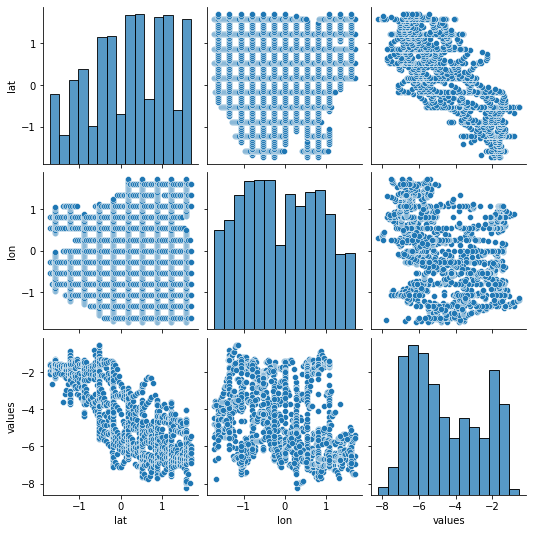

In [20]:
pairplot(df)

In [17]:
res_base = smf.ols(formula='values ~ lat + lon', data=df).fit()
res_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     2524.
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        07:19:03   Log-Likelihood:                -2471.8
No. Observations:                1783   AIC:                             4950.
Df Residuals:                    1780   BIC:                             4966.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2508      0.024   -179.901      0.000      -4.297      -4.204
lat           -1.5803      0.025    -64.061      0.000      -1.629      -1.532
lon           -0.6980      0.025    -27.804      0.000      -0.747      -0.649
==============================================================================
Omnibus:                       18.192   Durbin-Watson:                   0.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.315
Skew:                          -0.102   Prob(JB):                      0.00128
Kurtosis:                       2.629   Cond. No.                         1.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
res = smf.ols(formula='values ~ lat * lon', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     1687.
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        07:19:22   Log-Likelihood:                -2469.4
No. Observations:                1783   AIC:                             4947.
Df Residuals:                    1779   BIC:                             4969.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2555      0.024   -179.510      0.000      -4.302      -4.209
lat           -1.5750      0.025    -63.600      0.000      -1.624      -1.526
lon           -0.7270      0.028    -25.596      0.000      -0.783      -0.671
lat:lon        0.0649      0.030      2.174      0.030       0.006       0.123
==============================================================================
Omnibus:                       17.244   Durbin-Watson:                   0.648
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.178
Skew:                          -0.076   Prob(JB):                      0.00227
Kurtosis:                       2.625   Cond. No.                         1.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
res = smf.ols(formula='values ~ np.power(lon, 2) + np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     18.38
Date:                Sat, 07 Aug 2021   Prob (F-statistic):           1.26e-08
Time:                        07:24:59   Log-Likelihood:                -3652.0
No. Observations:                1783   AIC:                             7310.
Df Residuals:                    1780   BIC:                             7326.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.1617      0.080    -52.172      0.000      -4.318      -4.005
np.power(lon, 2)    -0.3067      0.055     -5.616      0.000      -0.414      -0.200
np.power(lat, 2)    -0.1213      0.052     -2.349      0.019      -0.223      -0.020
==============================================================================
Omnibus:                     1329.324   Durbin-Watson:                   0.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.732
Skew:                           0.304   Prob(JB):                     1.51e-29
Kurtosis:                       1.810   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
res = smf.ols(formula='values ~ lat + lat:lon', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     1611.
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        07:27:28   Log-Likelihood:                -2748.9
No. Observations:                1783   AIC:                             5504.
Df Residuals:                    1780   BIC:                             5520.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1796      0.028   -151.960      0.000      -4.234      -4.126
lat           -1.6293      0.029    -56.473      0.000      -1.686      -1.573
lat:lon       -0.2938      0.031     -9.532      0.000      -0.354      -0.233
==============================================================================
Omnibus:                       14.473   Durbin-Watson:                   0.451
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.367
Skew:                          -0.059   Prob(JB):                      0.00561
Kurtosis:                       2.645   Cond. No.                         1.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
res = smf.ols(formula='values ~ lat', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     2982.
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        07:28:18   Log-Likelihood:                -2793.3
No. Observations:                1783   AIC:                             5591.
Df Residuals:                    1781   BIC:                             5602.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1898      0.028   -148.744      0.000      -4.245      -4.135
lat           -1.6111      0.030    -54.604      0.000      -1.669      -1.553
==============================================================================
Omnibus:                       25.460   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.403
Skew:                          -0.027   Prob(JB):                     0.000452
Kurtosis:                       2.548   Cond. No.                         1.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Selected model

In [11]:
res_xco2 = smf.ols(formula='values ~ lon + lat', data=df).fit()
res_xco2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     2524.
Date:                Sat, 07 Aug 2021   Prob (F-statistic):               0.00
Time:                        08:03:41   Log-Likelihood:                -2471.8
No. Observations:                1783   AIC:                             4950.
Df Residuals:                    1780   BIC:                             4966.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2508      0.024   -179.901      0.000      -4.297      -4.204
lon           -0.6980      0.025    -27.804      0.000      -0.747      -0.649
lat           -1.5803      0.025    -64.061      0.000      -1.629      -1.532
==============================================================================
Omnibus:                       18.192   Durbin-Watson:                   0.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.315
Skew:                          -0.102   Prob(JB):                      0.00128
Kurtosis:                       2.629   Cond. No.                         1.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
mf.field_1.values = mf.field_1.values - res_xco2.predict()

## Look at the resulting fields

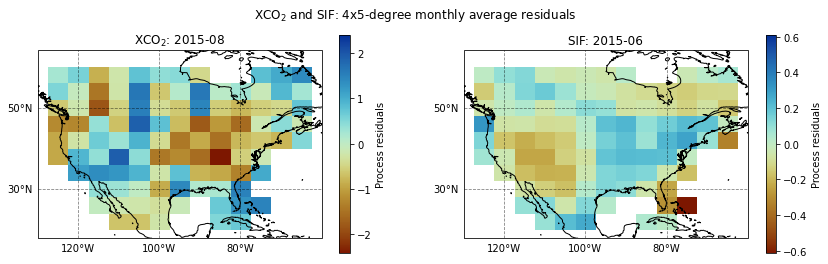

In [14]:
mf.field_1.ds = mf.field_1.to_xarray()
mf.field_2.ds = mf.field_2.to_xarray()
plot.plot_fields(mf)